# Configuración básica de una red neuronal recurrente.

Una vez hemos estudiado los conceptos básicos de los modelos secuenciales como las unidades recurrentes, GRU y LSTM, es hora de construir nuestra propia red. Como ejemplo usaremos una base de datos relacionada con la detección de Spam en mensajes de texto.

## Etapa 1: Se carga la base de datos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

tfds.disable_progress_bar()

In [2]:
# Se descarga el archivo zip que contiene la base de datos
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

--2023-02-25 22:24:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   778KB/s    in 0.3s    

2023-02-25 22:24:50 (778 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]



In [3]:
# Se descomprime el archivo zip
!unzip '/content/smsspamcollection.zip'

Archive:  /content/smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [4]:
# Ahora, se lee la base de datos
dataset = pd.read_csv('/content/SMSSpamCollection',sep='\t',names=['label','message'])

In [5]:
# Se tienen dos columnas, una de ellas es la etiqueta que puede ser spam o ham. 
# La etiqueta ham obedece a un mensaje que no es spam.
dataset.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Se le asigna una codificación numérica a cada etiqueta.
dataset['label'] = dataset['label'].map( {'spam': 1, 'ham': 0} )
dataset.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Se definen los conjuntos de entrenamiento y prueba.
X = dataset['message'].values
y = dataset['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
# Se generan mini-lotes de la base de datos
buffer_size = 10000
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Etapa 2: Procesamiento de textos

Recordemos que los modelos de aprendizaje no funcionan cuando las entradas son textos. Así, es necesaria una primera etapa en donde codificamos, de forma numérica, las cadenas de caracteres.

In [9]:
# El primer paso es convertir los caracteres a números. Una forma es a través
# de la función TextVectorization

Dicc_size = 1000 # Tamaño del diccionario, mientras mayor sea su tamaño se mejora
                 # su calidad; sin embargo, puede aumentar el tiempo de ejecución
                 # y la cantidad de parámetros de la red
encoder = tf.keras.layers.TextVectorization(max_tokens=Dicc_size)
encoder.adapt(train_dataset.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
# Elegimos un diccionario de 1000 palabras, acá mostramos una ejemplo de ellas.
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

# La idea del encoder es asignarle un número a cada palabra de acuerdo con su posición
# en el diccionario. Por ejemplo la palabra "the" tendría la codificación 6, puesto
# que dicha palabra ocupa la sexta posición.
# Por otro lado, se nota la presencia del elemento [UNK], el cual se usa para codificar
# palabras que no están dentro del diccionario elegido.

array(['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is',
       'me', 'my', 'for', 'your', 'it', 'of', 'call', 'have', 'on'],
      dtype='<U15')

## Etapa 3: Definición del modelo 



In [11]:
model = model = tf.keras.Sequential([
    # La primera parte de la red es el encoder que hemos definido previamente
    # Recordemos que la finalidad de este es darle una codificación numérica a 
    # cada palabra en la base datos
    encoder,

    # La segunda capa obedece a un embebimiento, el cual tiene como finalidad
    # mejorar la representación numérica de realizada por el encoder. La idea de 
    # los embebimientos es representar cada palabra a partir de un vector. Luego 
    # de la etapa de entrenamiento se espera que dos palabras cercanas 
    # tengan vectores similares.
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()), # tamaño de la entrada, el cual 
                                                 # equivale al tamaño del diccionario 
                                                 # que hemos elegido.
        output_dim=32, # Tamaño del vector a partir del cual se representará cada
                       # palabra.
        mask_zero=True # Este parámetro funciona como un "relleno". En general, es
                       # difícil garantizar que todos los mensajes tengan la 
                       # misma cantidad de palabras; así, las secuencias con un 
                       # tamaño menor al máximo, se rellenan con ceros.
      ),
    # Se define la segunda capa, la cual es una recurrente, con 24 unidades ocultas
    tf.keras.layers.SimpleRNN(24),

    # Finalmente, la capa de salida es una capa densa con una única unidad 
    # ya que se está solucionando un problema de clasificación binaria (Spam o Ham).
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 32)          32000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 24)                1368      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 33,393
Trainable params: 33,393
Non-trainable params: 0
_________________________________________________________________


# Etapa 4: Entrenamiento y evaluación del modelo

In [13]:
# Se compila el modelo usando el optimizador ADAM, se fija una función de costo 
# basada en entropía cruzada y se evalúa el rendimiento en términos del accuracy.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Se entrena el modelo para 10 épocas. 
history = model.fit(train_dataset, epochs=10,
          validation_data=test_dataset)




Epoch 1/10
70/70 [==============================] - 20s 149ms/step - loss: 0.3336 - accuracy: 0.8948 - val_loss: 0.1338 - val_accuracy: 0.9623
Epoch 2/10
70/70 [==============================] - 7s 96ms/step - loss: 0.1168 - accuracy: 0.9663 - val_loss: 0.0915 - val_accuracy: 0.9713
Epoch 3/10
70/70 [==============================] - 2s 31ms/step - loss: 0.0728 - accuracy: 0.9809 - val_loss: 0.0738 - val_accuracy: 0.9848
Epoch 4/10
70/70 [==============================] - 3s 39ms/step - loss: 0.0472 - accuracy: 0.9886 - val_loss: 0.0832 - val_accuracy: 0.9767
Epoch 5/10
70/70 [==============================] - 2s 30ms/step - loss: 0.0377 - accuracy: 0.9908 - val_loss: 0.0589 - val_accuracy: 0.9830
Epoch 6/10
70/70 [==============================] - 2s 32ms/step - loss: 0.0280 - accuracy: 0.9939 - val_loss: 0.0593 - val_accuracy: 0.9830
Epoch 7/10
70/70 [==============================] - 2s 30ms/step - loss: 0.0236 - accuracy: 0.9948 - val_loss: 0.0621 - val_accuracy: 0.9821
Epoch 8/10


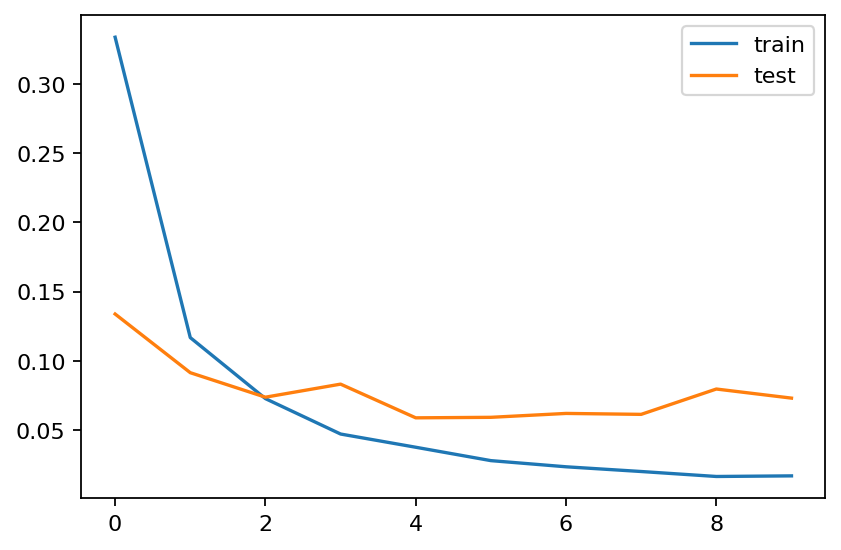

In [14]:
plt.figure(figsize=(6, 4), dpi=160)

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [15]:
# Finalmente, se evalúa el rendimiento del modelo en el conjunto de entrenamiento.
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print('Test accuracy:', test_acc)

18/18 - 0s - loss: 0.0731 - accuracy: 0.9812 - 146ms/epoch - 8ms/step
Test accuracy: 0.9811659455299377
